In [ ]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
import keras
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
 
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("drive/MyDrive/train.csv")
print("Train shape : ",train_df.shape)

Train shape :  (1306122, 3)


In [ ]:
## делим выборку на обучающую и тестовую
train_df, val_df = train_test_split(train_df, test_size=0.08, random_state=2022)

## задаем параметры 
embed_size = 300 # длина мах вектора (300, так как используем библиотеки .300)
max_features = 95000 # как много уникальный слов использовать (рандом)
maxlen = 70 # мах кол-во слов в предложении

## заполняем пропущенные значения
train_X = train_df["question_text"].fillna("_##_").values
val_X = val_df["question_text"].fillna("_##_").values

## маркирование
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)

## дополняем предложения до махлен
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)


## выделяем целевые значения
train_y = train_df['target'].values
val_y = val_df['target'].values

In [ ]:
# перемешиваем данные
np.random.seed(2022)
trn_idx = np.random.permutation(len(train_X))
val_idx = np.random.permutation(len(val_X))

train_X = train_X[trn_idx]
val_X = val_X[val_idx]
train_y = train_y[trn_idx]
val_y = val_y[val_idx]

In [ ]:
import pickle
pred_reg_val_y = pickle.load( open( "drive/MyDrive/save.p", "rb" ) )

In [ ]:
reg_val_y = pickle.load( open( "drive/MyDrive/save_vay.p", "rb" ) )

In [ ]:
EMBEDDING_FILE = 'drive/MyDrive/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
   
x = Bidirectional(LSTM(64, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(64, activation="relu")(conc)
conc = Dropout(0.1)(conc)
outp = Dense(1, activation="sigmoid")(conc)
model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Epoch 1/2
2347/2347 [==============================] - 3841s 2s/step - loss: 0.1118 - accuracy: 0.9562 - val_loss: 0.1025 - val_accuracy: 0.9586
Epoch 2/2
2347/2347 [==============================] - 3761s 2s/step - loss: 0.0909 - accuracy: 0.9636 - val_loss: 0.1027 - val_accuracy: 0.9585


In [ ]:
pred_lstm_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_lstm_val_y>thresh).astype(int))))

103/103 [==============================] - 86s 817ms/step
F1 score at threshold 0.1 is 0.6124266554903605
F1 score at threshold 0.11 is 0.6197333904384603
F1 score at threshold 0.12 is 0.626999290354277
F1 score at threshold 0.13 is 0.6328875076308341
F1 score at threshold 0.14 is 0.6387151310228233
F1 score at threshold 0.15 is 0.6422112853382167
F1 score at threshold 0.16 is 0.6460023174971031
F1 score at threshold 0.17 is 0.6499323966844982
F1 score at threshold 0.18 is 0.652862073069142
F1 score at threshold 0.19 is 0.6574219221029783
F1 score at threshold 0.2 is 0.6593500396317298
F1 score at threshold 0.21 is 0.6622246899870441
F1 score at threshold 0.22 is 0.6640878462690293
F1 score at threshold 0.23 is 0.665324609964771
F1 score at threshold 0.24 is 0.6668780518739299
F1 score at threshold 0.25 is 0.6677757870488866
F1 score at threshold 0.26 is 0.6688198436793488
F1 score at threshold 0.27 is 0.67188009123493
F1 score at threshold 0.28 is 0.6727619548773268
F1 score at thresh

In [ ]:
pickle.dump(pred_lstm_val_y, open( "lstm_save.p", "wb" ) )
pickle.dump(val_y, open( "lstm_save_vay.p", "wb" ) )

In [ ]:
from google.colab import files
files.download("lstm_save.p")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("lstm_save_vay.p")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lstm_precision = tf.keras.metrics.Precision(thresholds=0.41)
lstm_precision .update_state(val_y, pred_lstm_val_y)
print('lstm_precision : ', lstm_precision .result().numpy())

lstm_precision :  0.65737563


In [ ]:
lstm_Recall = tf.keras.metrics.Recall(thresholds=0.41)
lstm_Recall.update_state(val_y, pred_lstm_val_y)
print('lstm_Recall : ', lstm_Recall.result().numpy())

lstm_Recall :  0.6904369


In [ ]:
del word_index, embeddings_index, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)

In [ ]:
EMBEDDING_FILE = 'drive/MyDrive/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
filter_sizes = [1,2,3,5]
num_filters = 36

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Reshape((maxlen, embed_size, 1))(x)

maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                 kernel_initializer='he_normal', activation='relu')(x)
    maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

z = Concatenate(axis=1)(maxpool_pool)   
z = Flatten()(z)
z = Dropout(0.1)(z)

outp = Dense(1, activation="sigmoid")(z)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Epoch 1/2
2347/2347 [==============================] - 4533s 2s/step - loss: 0.1147 - accuracy: 0.9551 - val_loss: 0.1053 - val_accuracy: 0.9578
Epoch 2/2
2347/2347 [==============================] - 4509s 2s/step - loss: 0.0947 - accuracy: 0.9623 - val_loss: 0.1064 - val_accuracy: 0.9574


In [ ]:
pred_cnn_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_cnn_val_y>thresh).astype(int))))

103/103 [==============================] - 52s 499ms/step
F1 score at threshold 0.1 is 0.6008987139094055
F1 score at threshold 0.11 is 0.6101999788382182
F1 score at threshold 0.12 is 0.6201735357917572
F1 score at threshold 0.13 is 0.6282449522964277
F1 score at threshold 0.14 is 0.6341987668985802
F1 score at threshold 0.15 is 0.639668183651132
F1 score at threshold 0.16 is 0.6441214394561012
F1 score at threshold 0.17 is 0.6484682322088449
F1 score at threshold 0.18 is 0.6521291416802957
F1 score at threshold 0.19 is 0.6545722895270893
F1 score at threshold 0.2 is 0.6573767418609011
F1 score at threshold 0.21 is 0.6601757602579503
F1 score at threshold 0.22 is 0.6626143707210954
F1 score at threshold 0.23 is 0.6644664466446645
F1 score at threshold 0.24 is 0.6658801939965919
F1 score at threshold 0.25 is 0.6669319010675684
F1 score at threshold 0.26 is 0.6678729392842783
F1 score at threshold 0.27 is 0.6684274685087364
F1 score at threshold 0.28 is 0.6686738743670453
F1 score at th

In [ ]:
cnn_precision = tf.keras.metrics.Precision(thresholds=0.36)
cnn_precision .update_state(val_y, pred_cnn_val_y)
print('cnn_precision : ', cnn_precision .result().numpy())

cnn_precision :  0.6539747


In [ ]:
lstm_Recall = tf.keras.metrics.Recall(thresholds=0.36)
lstm_Recall.update_state(val_y, pred_cnn_val_y)
print('lstm_Recall : ', lstm_Recall.result().numpy())

lstm_Recall :  0.67557424


In [ ]:
pickle.dump(pred_cnn_val_y, open( "cnn_save.p", "wb" ) )
pickle.dump(val_y, open( "cnn_save_vay.p", "wb" ) )
files.download("cnn_save.p")
files.download("cnn_save_vay.p")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
del word_index, embeddings_index, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)

In [ ]:
EMBEDDING_FILE = 'drive/MyDrive/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
   
x = Bidirectional(LSTM(64, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(64, activation="relu")(conc)
conc = Dropout(0.1)(conc)
outp = Dense(1, activation="sigmoid")(conc)
model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Epoch 1/2
2347/2347 [==============================] - 3575s 2s/step - loss: 0.1144 - accuracy: 0.9556 - val_loss: 0.1048 - val_accuracy: 0.9575
Epoch 2/2
2347/2347 [==============================] - 3465s 1s/step - loss: 0.0914 - accuracy: 0.9634 - val_loss: 0.1057 - val_accuracy: 0.9582


In [ ]:
pred_fasttext_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_fasttext_val_y>thresh).astype(int))))

103/103 [==============================] - 88s 852ms/step
F1 score at threshold 0.1 is 0.6226158778460034
F1 score at threshold 0.11 is 0.6301035953686775
F1 score at threshold 0.12 is 0.6358459716975814
F1 score at threshold 0.13 is 0.6387584469132975
F1 score at threshold 0.14 is 0.6427866473149493
F1 score at threshold 0.15 is 0.6462208617847893
F1 score at threshold 0.16 is 0.6507387988560533
F1 score at threshold 0.17 is 0.6552263969171483
F1 score at threshold 0.18 is 0.6579043446513325
F1 score at threshold 0.19 is 0.6605109264389042
F1 score at threshold 0.2 is 0.6633866849349194
F1 score at threshold 0.21 is 0.665281973816717
F1 score at threshold 0.22 is 0.6651018207194062
F1 score at threshold 0.23 is 0.6667947732513451
F1 score at threshold 0.24 is 0.6673988887453159
F1 score at threshold 0.25 is 0.669361147327249
F1 score at threshold 0.26 is 0.6696469660114391
F1 score at threshold 0.27 is 0.6714010751974514
F1 score at threshold 0.28 is 0.6713090056913291
F1 score at thr

In [ ]:
fasttext_precision = tf.keras.metrics.Precision(thresholds=0.37)
fasttext_precision .update_state(val_y, pred_fasttext_val_y)
print('fasttext_precision : ', fasttext_precision .result().numpy())

fasttext_precision :  0.6398195


In [ ]:
fasttext_Recall = tf.keras.metrics.Recall(thresholds=0.37)
fasttext_Recall.update_state(val_y, pred_fasttext_val_y)
print('fasttext_Recall : ', fasttext_Recall.result().numpy())

fasttext_Recall :  0.70244706


In [ ]:
import pickle
from google.colab import files
pickle.dump(pred_fasttext_val_y, open( "fasttext_save.p", "wb" ) )
pickle.dump(val_y, open( "fasttext_save_vay.p", "wb" ) )
files.download("fasttext_save.p")
files.download("fasttext_save_vay.p")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
pred_reg_val_y = pickle.load( open( "drive/MyDrive/save.p", "rb" ) )

No handles with labels found to put in legend.


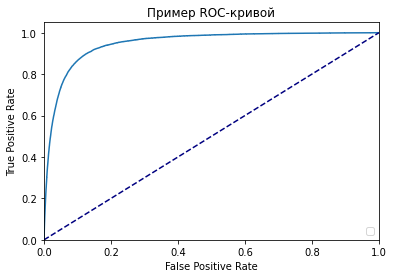

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve

fpr1, tpr1, treshold1 = roc_curve(reg_val_y, pred_reg_val_y)
plt.plot(fpr1, tpr1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()